*COMPUTER VISION - PROJECT 3*

Multi-view Image Sequence Estimation

# SetUp Requirements

## Download and unzip images

In [ ]:
%%capture
!pip install gdown -U --no-cache-dir

In [ ]:
%%capture
import gdown

url = 'https://drive.google.com/drive/folders/1KSPUaOa2D_4JmxyfXpE2nirnIi0ICjpN?usp=share_link'

gdown.download_folder(url)

In [ ]:
%%capture
!unzip "/content/cv_project/challenging.zip"
!unzip "/content/cv_project/easy.zip"

Archive:  /content/cv_project/challenging.zip
   creating: challenging/
  inflating: __MACOSX/._challenging  
  inflating: challenging/.DS_Store   
  inflating: __MACOSX/challenging/._.DS_Store  
   creating: challenging/upper_loop/
  inflating: __MACOSX/challenging/._upper_loop  
   creating: challenging/lower_loop/
  inflating: __MACOSX/challenging/._lower_loop  
  inflating: challenging/upper_loop/.DS_Store  
  inflating: __MACOSX/challenging/upper_loop/._.DS_Store  
   creating: challenging/upper_loop/rgb/
  inflating: __MACOSX/challenging/upper_loop/._rgb  
   creating: challenging/upper_loop/nir/
  inflating: __MACOSX/challenging/upper_loop/._nir  
  inflating: challenging/lower_loop/.DS_Store  
  inflating: __MACOSX/challenging/lower_loop/._.DS_Store  
   creating: challenging/lower_loop/rgb/
  inflating: __MACOSX/challenging/lower_loop/._rgb  
   creating: challenging/lower_loop/nir/
  inflating: __MACOSX/challenging/lower_loop/._nir  
  inflating: challenging/upper_loop/rgb/00

## Compile personal C library

In [ ]:
!g++ -fPIC -shared -std=c++11 -o libtsp.so cv_project/tspFun.cpp

## Load Libraries

In [ ]:
import os
from tqdm import tqdm

import cv2 as cv
import numpy as np

# Torch ResNet
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

# Visualization
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [ ]:
# Custom tsp library
import cv_project.tspFun as ts

# Functions

In [ ]:
def load_images(folder_path):
    img_paths = sorted(os.listdir(folder_path))
    images = [cv.imread(folder_path+fname) for fname in img_paths if not fname.startswith('.')]
    return images

def equalize_images(images):
    equalized_images = []
    for i in tqdm(range(n_img)):
        image = images[i]
        image_lab = cv.cvtColor(image, cv.COLOR_BGR2LAB) # even when it's not rgb, it works
        image_lab[:, :, 0] = cv.equalizeHist(image_lab[:, :, 0])
        image_eq = cv.cvtColor(image_lab, cv.COLOR_LAB2BGR)
        equalized_images.append(image_eq)
    return equalized_images

# Feature Extraction for each image
def feature_extraction(featureExtractor, images):
    n_img = len(images)
    kps = []
    descs = []

    for i in tqdm(range(n_img)):
        image = images[i]
        kp, desc = featureExtractor.detectAndCompute(image, None)
        kps.append(kp)
        descs.append(desc)
    return  kps, descs

# Feature Matching
def feature_matching(kps, descs, matcher, ratio_threshold):
    n_img = len(kps)
    # good_matches[i,j] = number of good matches between image i and image j
    good_matches = np.zeros((n_img, n_img))
    for i in tqdm(range(n_img)):
        desci = descs[i]
        kpi  = kps[i]
        for j in range(i+1, n_img):
            descj = descs[j]
            kpj   = kps[j]
            matches = matcher.knnMatch(desci, descj, k=2)
            good = []
            for m,n in matches:
                if m.distance < ratio_threshold*n.distance:
                    good.append([m])
            good_matches[i,j] = len(good)
            good_matches[j,i] = good_matches[i,j]
    return good_matches

# Deep Learning Functions:
def resnet_feature_extraction(model, preprocess, images):
    deep_features = []
    for img in tqdm(images):
        pilImg = Image.fromarray(img.astype('uint8')) # convert image to PIL Image
        input = preprocess(pilImg).unsqueeze(0) # preprocess and add batch dimension

        with torch.no_grad():
            feature_vector = model(input)
        deep_features.append(feature_vector.flatten().numpy())
    return np.array(deep_features)

def compute_similarity(deep_features, n_img):
    # compute cosine similarity: max 1, min -1, orthogonal if 0
    similarity_matrix = np.zeros((n_img, n_img))
    norms = [np.linalg.norm(deep_features[i, :]) for i in range(n_img)]
    for i in range(n_img):
        norm_i = norms[i]
        for j in range(n_img):
            dot_product = np.dot(deep_features[i, :], deep_features[j, :])
            norm_j = norms[j]
            similarity_matrix[i, j] = dot_product / (norm_i * norm_j)
    return similarity_matrix

# Visualization Functions:
def update_image(images, sequence, im, i):
    im.set_array(images[sequence[i]])
    im.axes.set_title(f'Image {sequence[i]}')
    return [im]

def visualize(images, tour, offset=0, types='',loop='', rgb='' ):
    sequence = tour[:]
    sequence = np.roll(sequence, offset) # make it start from the middle

    fig, ax = plt.subplots()
    im = ax.imshow(images[sequence[0]], animated=True)
    plt.axis('off')

    func = lambda i: update_image(images, sequence, im, i)

    animated_gif = FuncAnimation(fig, func, frames = len(tour), interval=300, blit=True)

    # save gif
    if types != '':
        animated_gif.save(f'./my_{types}_{loop}_{rgb}.gif', writer='pillow')

    # html viewer
    html = f""" <div style="display: flex; justify-content: center; align-items: center; flex-direction: column;">
                {animated_gif.to_jshtml()}
                </div>
            """
    plt.close(fig)
    return HTML(html)

# Loop Order Estimation

## Single Loop

### Load Images

In [ ]:
# Color Image Loading
level = "easy" # "easy", "challenging"
loop = "upper" # "lower", "upper"
rgbnir = "nir" #  "rgb" or "nir"

folder_path = f"./{level}/{loop}_loop/{rgbnir}/"
images = load_images(folder_path)
n_img  = len(images)

### Histogram Equalization

In [ ]:
# Histogram Equalization
equalized_images = equalize_images(images)

100%|██████████| 25/25 [00:00<00:00, 39.96it/s]


### SIFT Feature Extraction

In [ ]:
sift = cv.SIFT_create()

# Flann Matcher from https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict()

matcher = cv.FlannBasedMatcher(index_params, search_params) # smarter matcher


In [ ]:
# SIFT Feature Extraction for each image
kps, descs = feature_extraction(sift, equalized_images)

100%|██████████| 25/25 [00:10<00:00,  2.39it/s]


### Feature Matching

In [ ]:
# Feature Matching
ratio_threshold = 0.6
good_matches = feature_matching(kps, descs, matcher, ratio_threshold)

100%|██████████| 25/25 [00:14<00:00,  1.78it/s]


### Order Estimation

In [ ]:
tour = ts.solve_heuristic(-good_matches)

### Visualization

In [ ]:
visualize(images, tour)

### Draw Matches between close and far images

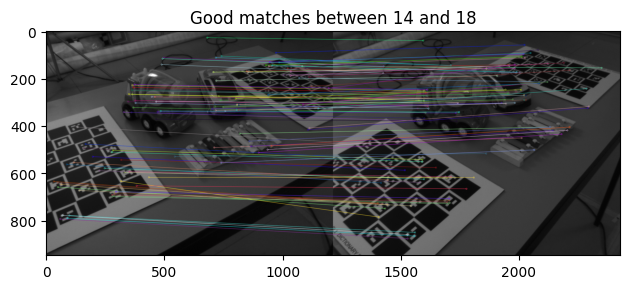

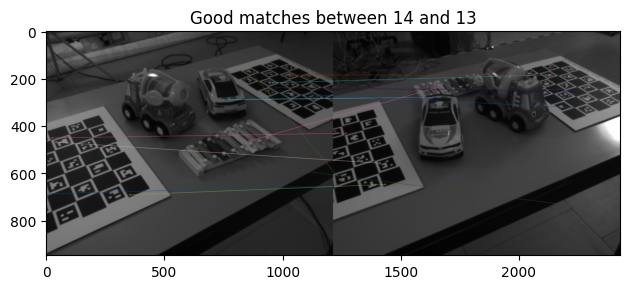

In [ ]:
# https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html
start = 2
idx0 = tour[start]
idx1 = tour[start+1]
idx2 = tour[start+13]

desci = descs[idx0]
kpi  = kps[idx0]
for j in [idx1, idx2]:
    descj = descs[j]
    kpj   = kps[j]
    matches = matcher.knnMatch(desci, descj, k=2)
    good = []
    for m,n in matches:
        if m.distance < 0.6*n.distance:
            good.append([m])
    img_match = cv.drawMatchesKnn(images[idx0],kpi,images[j],kpj,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(img_match)
    plt.title(f'Good matches between {idx0} and {j}')
    plt.tight_layout()
    plt.show()

# Including the Lower Loop
We cluster the feature vectors from the pretrained ResNet50 with KMeans, k=2.

It won't work also for nir images as probably ResNet50 was trained on rgb images

### Load Images

In [ ]:
# Color Image Loading
level = "easy" # "easy", "challenging"
rgbnir = "rgb" #  "rgb" or "nir"

loop1 = "upper" # "lower", "upper"
folder_path1 = f"./{level}/{loop1}_loop/{rgbnir}/"

loop2 = "lower" # "lower", "upper"
folder_path2 = f"./{level}/{loop2}_loop/{rgbnir}/"

images = load_images(folder_path1) + load_images(folder_path2)
n_img  = len(images)

### Histogram Equalization

In [ ]:
# Histogram Equalization
equalized_images = equalize_images(images)

100%|██████████| 50/50 [00:05<00:00,  8.62it/s]


### SIFT Feature Extraction

In [ ]:
sift = cv.SIFT_create()

# Flann Matcher from https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html
# Brute Force Matcher was too slow for n_img = 50
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict()

matcher = cv.FlannBasedMatcher(index_params, search_params) # smarter matcher


In [ ]:
# SIFT Feature Extraction for each image
kps, descs = feature_extraction(sift, equalized_images)

100%|██████████| 50/50 [01:20<00:00,  1.61s/it]


### Feature Matching

In [ ]:
# Feature Matching
ratio_threshold = 0.6
good_matches = feature_matching(kps, descs, matcher, ratio_threshold)

100%|██████████| 50/50 [02:22<00:00,  2.84s/it]


### Load Pretrained ResNet
https://docs.pytorch.org/vision/stable/models/generated/torchvision.models.resnet50.html

https://stackoverflow.com/questions/52548174/how-to-remove-the-last-fc-layer-from-a-resnet-model-in-pytorch



In [ ]:
weights = models.ResNet50_Weights.IMAGENET1K_V2
model = models.resnet50(weights=weights)
model = torch.nn.Sequential(*(list(model.children())[:-1]))
model.eval()
preprocess =  models.ResNet50_Weights.IMAGENET1K_V1.transforms() # take the transform used when training resnet50


### Feature Extraction

In [ ]:
deep_features = resnet_feature_extraction(model, preprocess, equalized_images)

100%|██████████| 50/50 [00:12<00:00,  3.96it/s]


### Classification
https://docs.opencv.org/3.4/d1/d5c/tutorial_py_kmeans_opencv.html

In [ ]:
k = 2 # two classes: lower and upper loop
maxiter = 1000
rerun = 1000
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, maxiter, 1.0)
flags = cv.KMEANS_PP_CENTERS

compactness, labels, centers = cv.kmeans( deep_features, k, None, criteria, rerun, flags)

labels = labels.flatten()
print(f'>> Class subdivision:\n {labels}')

>> Class subdivision:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


### Order loops separately

In [ ]:
idx0 = np.where(labels == 0)[0]
idx1 = np.where(labels == 1)[0]

# order separately the two loops using sift features
loop0_good_matches = good_matches[np.ix_(idx0, idx0)]
loop1_good_matches = good_matches[np.ix_(idx1, idx1)]

tour0 = ts.solve_heuristic(-loop0_good_matches)[:-1]
tour1 = ts.solve_heuristic(-loop1_good_matches)[:-1]

### Find closest link between loops

In [ ]:
similarity_matrix = compute_similarity(deep_features, n_img)

In [ ]:
# compute closest pair inter class using deep_features
cross_similarity = similarity_matrix[np.ix_(idx0,idx1)]
maxIdx = np.argmax(cross_similarity)
row, col = np.unravel_index(maxIdx, cross_similarity.shape)
print(f'link: {row}(group 0) -> {col}(group 1)')

# make tour0 ends in "row" and tour1 starts with "col" so we can stitch
roll0 = np.where(np.array(tour0) == row)[0][0]
roll1 = np.where(np.array(tour1) == col)[0][0]
sorted_tour0 = np.roll(tour0, -(roll0+1))
sorted_tour1 = np.roll(tour1, -roll1)

linked_loop = list(idx0[sorted_tour0])+list(idx1[sorted_tour1])
total_loop = [linked_loop[24]] + linked_loop+ [linked_loop[25]]

link: 7(group 0) -> 14(group 1)


#### Plot the link between loops

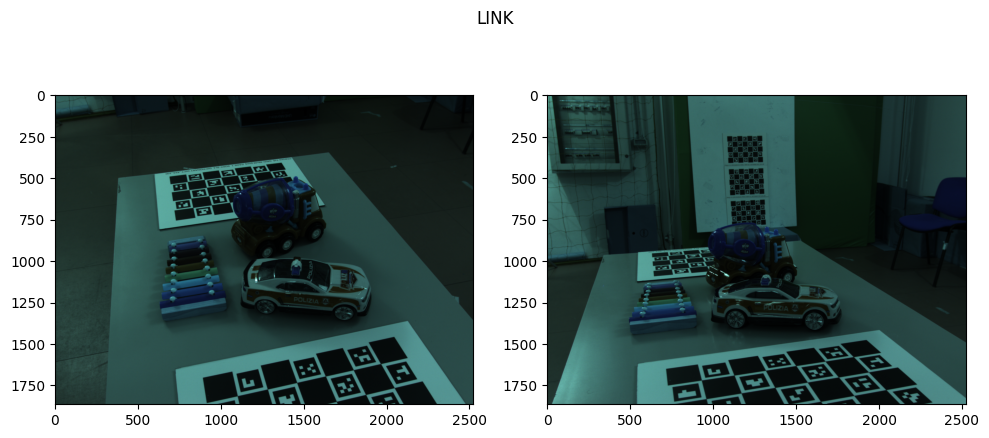

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(images[total_loop[25]])
axs[1].imshow(images[total_loop[26]])
fig.tight_layout()
plt.suptitle('LINK')
plt.show()

### Total Loop Visualization

In [ ]:
visualize(images, total_loop, offset=12, types= level, loop = 'total', rgb = 'loop')